# Comparing tweet categories through topic modelling

Use Twitter API to analyze **similarities** and **differences** between people tweeting about A vs people tweeting about B.

1. word cloud of words in tweets relating to category A and to category B
2. topic modelling of the words
3. geolocation of tweets and plot on map? (next)

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [28]:
import pyLDAvis.gensim, pyLDAvis

In [3]:
from gensim import corpora
from gensim.models import LsiModel, LdaModel

C:\Users\Mysterial\Miniconda3\envs\thinx\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
from gensim.models.tfidfmodel import TfidfModel #tfidf model from gensim

import os # os calls
import tweepy # python wrapper for api
import pickle # loading variables
import re # text processing
import string # text processing helper methods

In [5]:
with open('twitter_access_token.pkl', 'rb') as p:
    access = pickle.load(p)

In [6]:
token = ['', ''] # consumer key, consumer secret
access = ['', ''] # access key, access secret

try:
    if any([len(key)==0 for keys in zip(token, access) for key in keys]): # check if any entries of token or access are strings of length 0
        with open('twitter_consumer_token.pkl', 'rb') as p:
            token = pickle.load(p)
        with open('twitter_access_token.pkl', 'rb') as p:
            access = pickle.load(p)
except FileNotFoundError:
    raise Exception('Fill in the token and access fields in the script.')

In [7]:
auth = tweepy.OAuthHandler(*token)
auth.set_access_token(*access)

api = tweepy.API(auth)

In [8]:
# searching for tweets with lululemon and thinx
a_query = tweepy.Cursor(api.search, q='machine learning', tweet_mode='extended')
b_query = tweepy.Cursor(api.search, q='artifical intelligence', tweet_mode='extended')

In [15]:
def tweet_data(title, query, count=100, force=False, refresh=False):
    # force: switch for overriding pickled data
    # refresh: switch for refreshing data to the latest
    if title + '.pkl' not in os.listdir() or refresh:
        data = []
        for x in query.items(count):
            data.append(x)
        if force:
            with open(title + '.pkl', 'wb') as p:
                pickle.dump(data, p)
    else:
        with open(title + '.pkl', 'rb') as p:
            data = pickle.load(p)
    return data

a_data = tweet_data('a', a_query, count=400, refresh=True)
b_data = tweet_data('b', b_query, count=400, refresh=True)

In [10]:
# change to lowercase, remove url, remove all punctuation except hashtags
def clean(text):
# def clean(text, bytelen):
#     if not (len(text) <= len(text.encode()) - bytelen): # adjust bytelen to remove non-english tweets but include non-ascii tweets
    text = ''.join(char for char in text if char in string.printable) # filtered by individual character matching on ascii table
    text = text.lower() # lowercase
    text = re.sub('https?://[^\s]*', '', text) # remove urls
    punc = '[' + re.escape(string.punctuation.replace('#', '')) + ']' # remove punctuation from text, except hashtags
    text = re.sub(punc, '', text)
    text = re.sub('\s+', ' ', text) # remove duplicate spaces
    text = text.strip() # remove trailing spaces
    return text

# def tweet_extract(tweetobj, bytelen, retweet=False):
def tweet_extract(tweetobj, retweet=False):
    if not retweet: # remove retweets, looking for unique tweets only
        if tweetobj.retweeted or 'RT @' in tweetobj.full_text:
            return None
#     return clean(tweetobj.full_text, bytelen)
    return clean(tweetobj.full_text)

In [11]:
# split tweets into a list of string where each string represents each tweet
a_tweets = [tweet_extract(obj) for obj in a_data if tweet_extract(obj) is not None and len(tweet_extract(obj)) > 0]
b_tweets = [tweet_extract(obj) for obj in b_data if tweet_extract(obj) is not None and len(tweet_extract(obj)) > 0]
a_tweets = list(set(a_tweets))
b_tweets = list(set(b_tweets))

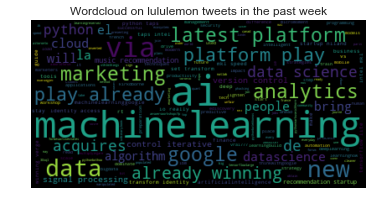

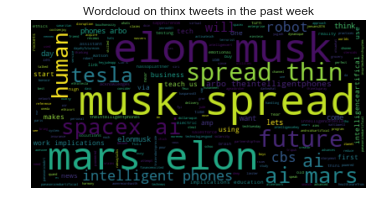

In [12]:
stopwords = set(STOPWORDS)
stopwords.update({'machine', 'learning', 'artificial', 'intelligence', 'artifical'})

# lower max_font_size
wordcloud = WordCloud(max_font_size=50, stopwords=stopwords).generate((''.join(a_tweets)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud on lululemon tweets in the past week')
plt.axis("off")
plt.show()

wordcloud = WordCloud(max_font_size=50, stopwords=stopwords).generate((''.join(b_tweets)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud on thinx tweets in the past week')
plt.axis("off")
plt.show()

### tf-idf on tweets

**Pipeline** <br>
1. split each tweet into a list of words; \_ = [x.split for x in tweets] <br>
2. create a dict of words; dict = corpora.Dictionary(\_)<br>
3. create token maps for dict; tokens = dict.token2id<br>
4. convert tweet to vectors; corpus = [dict.doc2bow(x) for x in \_]<br>
5. create model; model = TfidfModel(corpus=corpus) <br>
6. obtain tfidf scores; \_ = model[tokens] <br>
7. convert tokens back to words; tfidf\_token2id[\_]

In [13]:
stopwords = set(STOPWORDS)
stopwords.update({'machine', 'learning', 'artificial', 'intelligence', 'artifical'})

# create a dict of tweet words
def dictionary(tweets):
    return corpora.Dictionary(tweets)

# tokenise tweets using corpora.Dictionary
def tokenise_corpus(tweets, dictionary):
    return [dictionary.doc2bow(tweet) for tweet in tweets]

# # tokenise tweets using corpora.Dictionary
# def tokenise_corpus(tweets, dictionary):
#     return [dictionary.doc2bow(tweet.split()) for tweet in tweets]

# training a tfidf model
def tfidf_model(tokenised_corpus):
    return TfidfModel(corpus=tokenised_corpus)

# use a tfidf model to transform the tokenised tweets to tfidf tweets
def tfidf_corpus(model, tokenised_corpus):
    return model[tokenised_corpus]

def tfidf_token2id(tfidf_corpus, dictionary):
    '''
    This function takes in the generator expression from TfidfModel(corpus)[corpus] and outputs a dictionary of word-tfidf score
    '''
    id2tfidf = {}

    for line in tfidf_corpus:
        for ID, freq in line:
            pair = {dictionary.get(ID): freq}
            id2tfidf.update(pair)
    return id2tfidf

# def tfidf_token2id(tfidf_corpus, dictionary, stopwords=stopwords):
#     '''
#     This function takes in the generator expression from TfidfModel(corpus)[corpus] and outputs a dictionary of word-tfidf score
#     '''
#     id2tfidf = {}

#     for line in tfidf_corpus:
#         for ID, freq in line:
#             pair = {dictionary.get(ID): freq}
#             id2tfidf.update(pair)
#     not_found = []
#     for x in stopwords:
#         try:
#             del id2tfidf[x]
#         except KeyError:
#             not_found.append(x)
#     return id2tfidf, not_found

# a class that contains all the outputs that are useful for tf-idf, lsi, lda from gensim
class corpora_pipe(object):
    def __init__(self, tweets, stopwords):
        """ valid methods: tweets, stopwords, dict, tokens
        """
        tweets = [tweet for tweet in tweets if len(tweet.split()) > 4] # removes tweets if the word count is < 5
        self.tweets = [[word for word in tweet.split() if word not in stopwords] for tweet in tweets] # split tweets, remove words in stopwords
        self.stopwords = stopwords
        self.dict = dictionary(self.tweets)
        self.tokens = tokenise_corpus(self.tweets, self.dict)

# a tfidf pipeline that inherits from corpora_pipe, returns word: tfidf frequency and excluded stopwords
class tfidf_pipeline(corpora_pipe):
    def __init__(self, tweets, stopwords):
        corpora_pipe.__init__(self, tweets, stopwords)
        self.model = tfidf_model(self.tokens)
        self.corpus = list(tfidf_corpus(self.model, self.tokens))
        self.tfidf = tfidf_token2id(self.corpus, self.dict)
    def transform(self):
        return self.tfidf


# l_dictionary = dictionary(l_tweets)
# t_dictionary = dictionary(t_tweets)

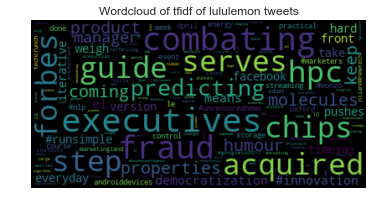

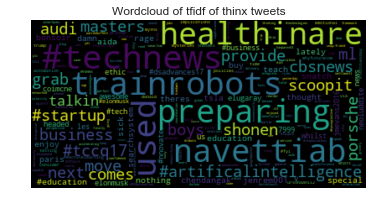

In [18]:
plt.imshow(WordCloud(max_font_size=40, stopwords=stopwords).generate_from_frequencies(frequencies=tfidf_pipeline(a_tweets, stopwords).transform()), interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of tfidf of a tweets')
plt.show()

plt.imshow(WordCloud(max_font_size=40, stopwords=stopwords).generate_from_frequencies(frequencies=tfidf_pipeline(b_tweets, stopwords).transform()), interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of tfidf of b tweets')
plt.show()

### LSI

In [22]:
a_tfidf = tfidf_pipeline(a_tweets, stopwords)
b_tfidf = tfidf_pipeline(b_tweets, stopwords)
a_lsi = LsiModel(a_tfidf.corpus, id2word=a_tfidf.dict, num_topics=5)
corpus_list = a_lsi[a_tfidf.corpus]
# for topic in corpus_list:
#     print(topic)

In [23]:
# distinct topics, similar to pca
a_lsi.show_topics(num_words=5)

[(0,
  '0.373*"already" + 0.373*"winning" + 0.373*"platform" + 0.373*"play" + 0.361*"googles"'),
 (1,
  '-0.398*"spotify" + -0.398*"startup" + -0.364*"niland" + -0.360*"acquires" + -0.360*"music"'),
 (2,
  '-0.420*"data" + -0.291*"iterative" + -0.291*"version" + -0.283*"control" + -0.221*"#machinelearning"'),
 (3,
  '0.400*"google" + 0.322*"io" + 0.315*"really" + 0.301*"ai" + 0.301*"people"'),
 (4,
  '0.461*"810" + 0.461*"workshopcfp" + 0.461*"signal" + 0.461*"processing" + 0.167*"lt"')]

### LDA

In [ ]:
# ldavis -visualise the topics for each set of corpus separately, but how do you analyse the similarities and differences?
# maybe: plot both corpus together and then tag the tweets with topics
# semantic distance between topics on scatterplot

In [88]:
pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(b_lda.get_document_topics(b_pipe.tokens))]).sum()

0    17.956710
1    12.136778
2    17.027077
3    27.948168
4    15.931267
dtype: float64

In [117]:
full_tweets = a_tweets + b_tweets
# a_pipe = corpora_pipe(a_tweets, stopwords)
# b_pipe = corpora_pipe(b_tweets, stopwords)

full_pipe = corpora_pipe(full_tweets, stopwords)
%time full_lda = LdaModel(full_pipe.tokens, num_topics=5, \
                     id2word=full_pipe.dict, \
                     passes = 100)

Wall time: 39.4 s


In [ ]:
# stopwords need to be removed during data processing stage, include stopwords filtering in corpora_pipe

In [118]:
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.gensim.prepare(topic_model=full_lda, corpus=full_pipe.tokens, dictionary=full_pipe.dict)
pyLDAvis.display(lda_vis)

In [120]:
pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(a_pipe.tokens))]).sum()

0    44.253888
1    17.957331
2    18.051650
3    26.586077
4    15.151054
dtype: float64

In [ ]:
# sns stacked barplot of all the topics with the proportion of tweets in each topic

In [51]:
a_df = pd.DataFrame([[tweet, cat] for tweet, cat in zip(a_tweets, ['a'] * len(a_tweets))], columns=['tweet', 'category'])
b_df = pd.DataFrame([[tweet, cat] for tweet, cat in zip(b_tweets, ['b'] * len(b_tweets))], columns=['tweet', 'category'])
df = a_df.append(b_df)

In [280]:
test = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(full_pipe.tokens[:122]))])
test2 = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(full_pipe.tokens[122:]))])
test3 = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in list(full_lda.get_document_topics(full_pipe.tokens))])

In [341]:
len(list(full_lda.get_document_topics(full_pipe.tokens)))

213

In [473]:
def most_probable_topics(p_list):
    dict_df = [{topic: 1} for tweet in p_list for topic, prob in enumerate(tweet) if max(tweet) == prob]
    df = pd.DataFrame(dict_df)
    return df

In [474]:
test4 = [[prob for topic, prob in tweet] for tweet in list(full_lda.get_document_topics(full_pipe.tokens[:122]))]
# test4 = [topic for tweet in test4 for topic, prob in enumerate(tweet) if max(tweet) == prob]
# test4 = pd.DataFrame([Counter(test4)])
test4 = most_probable_topics(test4)
# test4 = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in test4])
test5 = [[prob for topic, prob in tweet] for tweet in list(full_lda.get_document_topics(full_pipe.tokens[122:]))]
# test5 = [topic for tweet in test5 for topic, prob in enumerate(tweet) if max(tweet) == prob]
test5 = most_probable_topics(test5)
# test5 = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in test5])
test6 = [[prob for topic, prob in tweet] for tweet in list(full_lda.get_document_topics(full_pipe.tokens))]
test6 = most_probable_topics(test6)
# test6 = pd.DataFrame([{topic: prob for topic, prob in tweet} for tweet in test6])

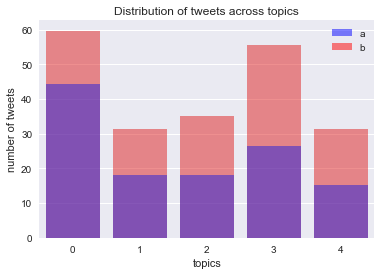

[(0,
  '0.025*"#machinelearning" + 0.015*"#ai" + 0.013*"data" + 0.011*"intelligent" + 0.011*"phones"'),
 (1, '0.015*"#ai" + 0.010*"de" + 0.010*"#tech" + 0.008*"work" + 0.008*"data"'),
 (2,
  '0.019*"future" + 0.017*"ai" + 0.009*"via" + 0.009*"lets" + 0.007*"think"'),
 (3,
  '0.029*"spread" + 0.029*"thin" + 0.027*"musk" + 0.026*"elon" + 0.023*"mars"'),
 (4, '0.025*"human" + 0.014*"news" + 0.012*"us" + 0.012*"#ai" + 0.012*"cbs"')]

In [375]:
sns.barplot(data=test3.sum().to_frame().transpose(), color='red', alpha=0.5)
sns.barplot(data=test.sum().to_frame().transpose(), color='blue', alpha=0.5)
plt.xlabel('topics')
plt.ylabel('number of tweets')
fbar = plt.Rectangle((0,0),1,1, fc="red", edgecolor = 'none', alpha=0.5)
abar = plt.Rectangle((0,0),1,1, fc='blue',  edgecolor = 'none', alpha=0.5)
plt.legend([abar, fbar], ['a', 'b'])
plt.title('Distribution of tweets across topics')
plt.show()
full_lda.show_topics(num_words=5)

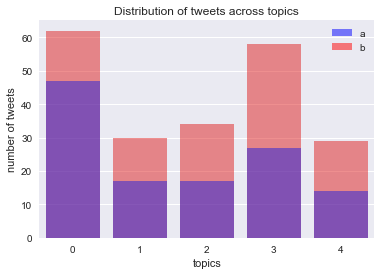

[(0,
  '0.025*"#machinelearning" + 0.015*"#ai" + 0.013*"data" + 0.011*"intelligent" + 0.011*"phones"'),
 (1, '0.015*"#ai" + 0.010*"de" + 0.010*"#tech" + 0.008*"work" + 0.008*"data"'),
 (2,
  '0.019*"future" + 0.017*"ai" + 0.009*"via" + 0.009*"lets" + 0.007*"think"'),
 (3,
  '0.029*"spread" + 0.029*"thin" + 0.027*"musk" + 0.026*"elon" + 0.023*"mars"'),
 (4, '0.025*"human" + 0.014*"news" + 0.012*"us" + 0.012*"#ai" + 0.012*"cbs"')]

In [481]:
sns.barplot(data=test6.sum().to_frame().transpose(), color='red', alpha=0.5)
sns.barplot(data=test4.sum().to_frame().transpose(), color='blue', alpha=0.5)
plt.xlabel('topics')
plt.ylabel('number of tweets')
fbar = plt.Rectangle((0,0),1,1, fc="red", edgecolor = 'none', alpha=0.5)
abar = plt.Rectangle((0,0),1,1, fc='blue',  edgecolor = 'none', alpha=0.5)
plt.legend([abar, fbar], ['a', 'b'])
plt.title('Distribution of tweets across topics')
plt.show()
full_lda.show_topics(num_words=5)

In [ ]:
# makes not much difference whether tweets are distributed over the topics according to percentage or as a class
# find another two topics to measure

In [ ]:
# new approach - merge the two corpuses together, generate ldavis on the combined corpus, 
# circle colour shade of hue depending on how many belong to one class

### Approach 2 - geoloc on tweets

In [188]:
# split tweets into a list of string where each string represents each tweet
tweets = [tweet_extract(obj) for obj in data if tweet_extract(obj) is not None]

In [ ]:
# library on plotting geolocation: http://wrobstory.github.io/2013/04/python-maps-choropleth.html

In [429]:
[[count, x.geo] for count, x in enumerate(data) if x.user.geo_enabled]

[[1, None],
 [2, {'coordinates': [27.7801, -82.1447], 'type': 'Point'}],
 [3, None],
 [9, {'coordinates': [35.70379772, 139.57681226], 'type': 'Point'}],
 [13, None],
 [15, None],
 [16, None],
 [17, {'coordinates': [32.7893, -79.9863], 'type': 'Point'}],
 [19, None],
 [28, None],
 [32, {'coordinates': [26.158469, -80.3255512], 'type': 'Point'}],
 [33, None],
 [35, None],
 [36, None],
 [38, None],
 [40, None],
 [42, {'coordinates': [1.28103126, 103.8575168], 'type': 'Point'}],
 [46, None],
 [52, {'coordinates': [40.72548885, -74.00002842], 'type': 'Point'}],
 [54, None],
 [59, None],
 [60, None],
 [62, None],
 [63, None],
 [67, None],
 [68, {'coordinates': [40.740523, -73.985629], 'type': 'Point'}],
 [69, {'coordinates': [40.73226926, -74.00360738], 'type': 'Point'}],
 [70, None],
 [71, None],
 [73, None],
 [74, {'coordinates': [42.48541177, -71.21186511], 'type': 'Point'}],
 [76, None],
 [77, None],
 [78, None],
 [79, None],
 [85, None],
 [86, {'coordinates': [50.1167, 8.68333], 'type'

In [390]:
[x.coordinates for x in data if x.user.geo_enabled]

[None,
 {'coordinates': [-82.1447, 27.7801], 'type': 'Point'},
 None,
 {'coordinates': [139.57681226, 35.70379772], 'type': 'Point'},
 None,
 None,
 None,
 {'coordinates': [-79.9863, 32.7893], 'type': 'Point'},
 None,
 None,
 {'coordinates': [-80.3255512, 26.158469], 'type': 'Point'},
 None,
 None,
 None,
 None,
 None,
 {'coordinates': [103.8575168, 1.28103126], 'type': 'Point'},
 None,
 {'coordinates': [-74.00002842, 40.72548885], 'type': 'Point'},
 None,
 None,
 None,
 None,
 None,
 None,
 {'coordinates': [-73.985629, 40.740523], 'type': 'Point'},
 {'coordinates': [-74.00360738, 40.73226926], 'type': 'Point'},
 None,
 None,
 None,
 {'coordinates': [-71.21186511, 42.48541177], 'type': 'Point'},
 None,
 None,
 None,
 None,
 None,
 {'coordinates': [8.68333, 50.1167], 'type': 'Point'},
 None,
 None,
 {'coordinates': [101.67133095, 3.13172658], 'type': 'Point'},
 None,
 None,
 None,
 None,
 None]

In [135]:
import pandas as pd

In [139]:
pd.read_json(path_or_buf=x._json, orient='records')

TypeError: Expected String or Unicode